In [1]:
%reset
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import random
import treecorr
from astropy.io import fits
import pickle as pk
import os.path
from os import path
import colossus
from colossus.cosmology import cosmology
from colossus.lss import bias
from colossus.lss import mass_function
from colossus.halo import mass_so
from colossus.halo import mass_defs
from colossus.halo import concentration
from esutil.coords import randsphere
import scipy.signal as spsg
import astropy.units as u
from astropy import constants as const
import scipy as sp
sys.path.insert(0,'/global/project/projectdirs/des/shivamp/cosmosis/y3kp-bias-model/3d_stats/process_measure_data/')
import process_cats_class as pcc
# import fitsio
# from fitsio import FITS,FITSHDR




Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa
/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [61]:
cat_old = fits.open('/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/process_cats/matter_ra_dec_r_z_bin_jk_L3072N4096-LC129-1in700_njkradec_180_njkz_1.fits')

ra_o, dec_o, z_o = cat_old[1].data['RA'], cat_old[1].data['DEC'], cat_old[1].data['Z']
ra_min = 0. 
dec_min = 0.
ra_max = 90.
dec_max = 90.
z_min = np.min(z_o)
z_max = np.max(z_o)







In [62]:
nzbins_total = 5000
zarray_all = np.linspace(z_min, z_max, nzbins_total)
zarray_edges = (zarray_all[1:] + zarray_all[:-1]) / 2.
zarray = zarray_all[1:-1]




In [63]:


n_rand = len(ra_o)*2
ra_r, dec_r = randsphere(n_rand, ra_range=[ra_min,ra_max], dec_range=[dec_min, dec_max])






In [64]:
nz_unnorm, z_edge = np.histogram(z_o, zarray_edges)
nz_normed = nz_unnorm/(integrate.simps(nz_unnorm,zarray))



In [65]:

nz_normed_smooth = spsg.savgol_filter(nz_normed, 451, 5)



In [66]:

def get_Dcom_array(zarray, Omega_m):
    Omega_L = 1. - Omega_m
    c = 3 * 10 ** 5
    Dcom_array = np.zeros(len(zarray))
    for j in xrange(len(zarray)):
        zf = zarray[j]
        res1 = sp.integrate.quad(lambda z: (c / 100) * (1 / (np.sqrt(Omega_L + Omega_m * ((1 + z) ** 3)))), 0, zf)
        Dcom = res1[0]
        Dcom_array[j] = Dcom
    return Dcom_array

def get_Hz(zarray, Omega_m):
    Omega_L = 1 - Omega_m
    Ez = np.sqrt(Omega_m * (1 + zarray) ** 3 + Omega_L)
    Hz = 100. * Ez
    return Hz

Omega_m = 0.25

chi_array = get_Dcom_array(zarray, Omega_m)
dchi_dz_array = (const.c.to(u.km / u.s)).value / (get_Hz(zarray, Omega_m))

chi_max = get_Dcom_array([z_max], Omega_m)[0]
chi_min = get_Dcom_array([z_min], Omega_m)[0]
VT = (4*np.pi/3)* (chi_max**3 - chi_min**3)
dndz = (4*np.pi)* (chi_array**2) * dchi_dz_array / VT




In [67]:

dndm_model = 'crocce10'
bias_model = 'bhattacharya11'
mdef = 'fof'
cosmo_params = {'flat': True, 'H0': 70.0, 'Om0': 0.25, 'Ob0': 0.0448, 'sigma8': 0.8, 'ns': 0.95}


cosmology.addCosmology('mock_cosmo', cosmo_params)
cosmo_colossus = cosmology.setCosmology('mock_cosmo')
h = cosmo_params['H0'] / 100.


# get the halo mass function and halo bias using the colossus module
def get_dndm_bias(M_mat,z_array, mdef):

    dndm_array_Mz, bm_array_Mz = np.zeros(M_mat.shape), np.zeros(M_mat.shape)

    for j in range(len(z_array)):
        M_array = M_mat[j, :]
        dndm_array_Mz[j, :] = (1. / M_array) * mass_function.massFunction(M_array, z_array[j],mdef=mdef, model=dndm_model,q_out='dndlnM')

        bm_array_Mz[j, :] = bias.haloBias(M_array, z_array[j], model=bias_model, mdef=mdef)

    return dndm_array_Mz, bm_array_Mz


M_array = np.logspace(11,16,2000)
nm = len(M_array)
nz = len(zarray)
M_mat = np.tile(M_array.reshape(1, nm), (nz, 1))


dndm_array, bm_array = get_dndm_bias(M_mat,zarray, mdef)






In [68]:
massbin_min = [12.0, 12.5, 13.0, 13.5, 14.0]
massbin_max = [12.5, 13.0, 13.5, 14.0, 14.5]
halo_inp = fits.open('/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/MICE_allhalos_Mlow_1e12.fits')
jm = 4
lmhalo_min = massbin_min[jm]
lmhalo_max = massbin_max[jm]

ind_sel = np.where( (M_mat < 10**lmhalo_min) | (M_mat > 10**lmhalo_max))
dndm_Mmat_bin = np.copy(dndm_array)
dndm_Mmat_bin[ind_sel] = 0.0
nbar_zarray = sp.integrate.simps(dndm_Mmat_bin, M_array)
dNdz_array = nbar_zarray * (4*np.pi)* (chi_array**2) * dchi_dz_array 
N_T = sp.integrate.simps(dNdz_array, zarray)
dndz_g = dNdz_array/N_T

ra_all, dec_all, z_all, lmhalo_all = halo_inp[1].data['ra_gal'],halo_inp[1].data['dec_gal'],halo_inp[1].data['z_cgal'], halo_inp[1].data['lmhalo']
ind = np.where((lmhalo_all >= lmhalo_min)  & (lmhalo_all <= lmhalo_max) )[0]
ra_g, dec_g, z_g = ra_all[ind], dec_all[ind], z_all[ind]

nz_unnorm_g, z_edge = np.histogram(z_g, zarray_edges)
nz_normed_g = nz_unnorm_g/(integrate.simps(nz_unnorm_g,zarray))




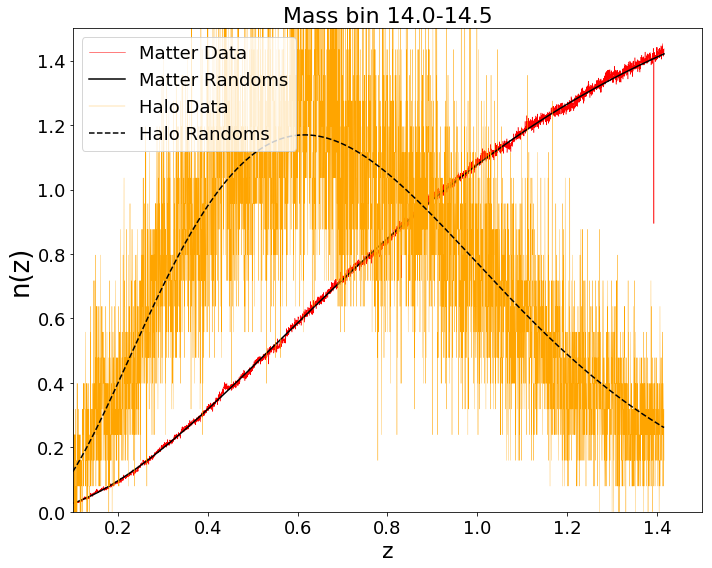

In [69]:
fig, ax = plt.subplots(1,1, figsize = (10,8))
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(0.1,1.5)
ax.set_ylim(0.0,1.5)
ax.plot(zarray, nz_normed, 'r-', label='Matter Data',linewidth=0.5)
ax.plot(zarray, dndz, 'k-', label='Matter Randoms')
ax.plot(zarray, nz_normed_g, 'orange', label='Halo Data',linewidth=0.3)
ax.plot(zarray, dndz_g , 'k--', label='Halo Randoms')

ax.legend(fontsize=18, loc='upper left')
plt.xlabel(r'z', fontsize=22)
plt.ylabel(r'n(z)', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)
plt.title('Mass bin ' + str(lmhalo_min)  + '-' + str(lmhalo_max), size=22)
plt.tight_layout()
# plt.savefig('/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/process_cats/halos_nz_M_13.0_13.5_theory.png')



In [70]:
zmin_bins = [0.15,0.3,0.45,0.6,0.75]
zmax_bins = [0.3,0.45,0.6,0.75,0.9]
savenz_dir = '/global/project/projectdirs/des/y3-bias/MICE_all_data/v2/nz_halos/'
for j in range(len(zmin_bins)):
    zl = zmin_bins[j]
    zh = zmax_bins[j]
    ind_sel = np.where( (z_g > zl) & (z_g < zh))[0]
    z_g_j = z_g[ind_sel]
    
    ind_sel_m = np.where( (z_o > zl) & (z_o < zh))[0]
    z_m_j = z_o[ind_sel_m]
    
    nz_unnorm_g, z_edge = np.histogram(z_g_j, zarray_edges)
    nz_normed_g = nz_unnorm_g/(integrate.simps(nz_unnorm_g,zarray))
    
    nz_unnorm, z_edge = np.histogram(z_m_j, zarray_edges)
    nz_normed = nz_unnorm/(integrate.simps(nz_unnorm,zarray))
    
    nz_dict = {'nz_g':nz_normed_g, 'nz_m':nz_normed, 'nz_z':zarray}
    save_fname = '/global/project/projectdirs/des/y3-bias/MICE_all_data/v2/nz_halos/' + 'halos_' + str(lmhalo_min) + '_' + str(lmhalo_max) + '/' + 'nz_g_m_' + '_zbin_' + str(j + 1) + '_dsg_' + str(1) + '_dsm_' + str(1) + '.pk'  
    
    pk.dump(nz_dict, open(save_fname, 'wb'), protocol=2)
    
    
    



In [12]:
zb_min = 0.3
zb_max = 0.45
lmhalo_min = 13.0
lmhalo_max = 13.5

z_mat = np.tile(zarray.reshape(nz, 1), (1, nm))
ind_selM = np.where( (M_mat < 10**lmhalo_min) | (M_mat > 10**lmhalo_max))
ind_selz = np.where( (z_mat < zb_min) | (z_mat > zb_max))
dndm_Mmat_bin = np.copy(dndm_array)
dndm_Mmat_bin[ind_selM] = 0.0
dndm_Mmat_bin[ind_selz] = 0.0
mean_bias = sp.integrate.simps(sp.integrate.simps(dndm_Mmat_bin * bm_array, M_array),zarray)/(sp.integrate.simps(sp.integrate.simps(dndm_Mmat_bin, M_array),zarray))     
print(mean_bias)



1.5304833062390042


In [13]:
minrad = 0.8
maxrad = 50.0
nrad = 20
binval = 2
do_jk = True
njk_radec = 180
njk_z = 1
ds_g_inp = 1
ds_g = 1
ds_m_inp = 1
ds_m = 1
save_dir_gg_gm = '/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/measurements/halo_' + str(lmhalo_min) + '_' + str(lmhalo_max) + '/'

save_filename_gg_mm = 'gg_mm_lmhalo_' + str(lmhalo_min) + '_' + str(lmhalo_max) + '_3dcorr_r_' + str(minrad) + '_' + str(maxrad) + '_nr_' + str(nrad) + '_zbin_' + str(
    binval) + '_jk_' + str(do_jk) + '_njkradec_' + str(njk_radec) + '_njkz_' + str(njk_z) + '_dsg_' + str(
    ds_g_inp*ds_g) + '_dsm_' + str(ds_m_inp*ds_m) + '_th_nz_v1_lbs.pk'
save_filename_gm_mm = 'gm_mm_lmhalo_' + str(lmhalo_min) + '_' + str(lmhalo_max) + '_3dcorr_r_' + str(minrad) + '_' + str(maxrad) + '_nr_' + str(nrad) + '_zbin_' + str(
    binval) + '_jk_' + str(do_jk) + '_njkradec_' + str(njk_radec) + '_njkz_' + str(njk_z) + '_dsg_' + str(
    ds_g_inp*ds_g) + '_dsm_' + str(ds_m_inp*ds_m) + '_th_nz_v1_lbs.pk'
output_data_gg_mm = pk.load(open(save_dir_gg_gm + save_filename_gg_mm, "rb"))
output_data_gm_mm = pk.load(open(save_dir_gg_gm + save_filename_gm_mm, "rb"))




/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


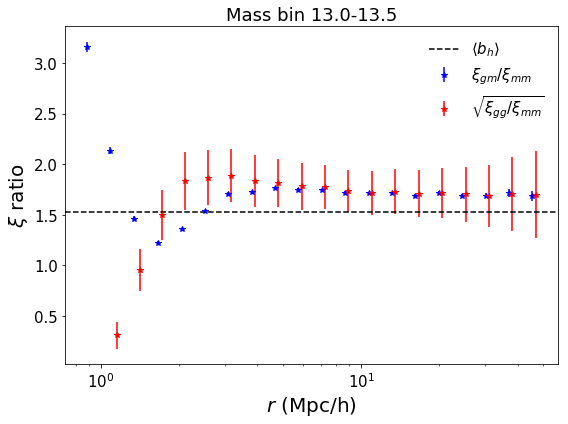

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

j = 0


if output_data_gm_mm is not None:
    ax.errorbar((1.03**j)*output_data_gm_mm['r_gm'], output_data_gm_mm['xi_gm_mm_full'], output_data_gm_mm['sig'], color='blue', label=r'$\xi_{gm}/\xi_{mm}$', marker='*', linestyle='')
    j += 1

if output_data_gg_mm is not None:
    ax.errorbar((1.03**j)*output_data_gg_mm['r_gg'], np.sqrt(output_data_gg_mm['xi_gg_mm_full']),np.sqrt( output_data_gg_mm['sig']), color='red', label=r'$\sqrt{\xi_{gg}/\xi_{mm}}$', marker='*', linestyle='')
    j += 1
ax.axhline(mean_bias,xmin=0.0,xmax=50,linestyle='--', color='k', label=r'$\langle b_h \rangle$')

ax.legend(fontsize=15, frameon=False)
ax.set_xlabel(r'$r$ (Mpc/h)' , size=20)
ax.set_ylabel(r'$\xi$ ratio', size=20)
ax.set_xscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.title('Mass bin ' + str(lmhalo_min)  + '-' + str(lmhalo_max), size=18)
plt.tight_layout()
plt.savefig('/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/measurements/halo_13.0_13.5/halo_bias_measure_comp_lbs.png')

# plt.savefig(plot_save_name)



In [19]:
zmin_hdens = 0.15
zmax_hdens = 0.6
zmin_hlum = 0.6
zmax_hlum = 0.75
zmin_hrlum = 0.75
zmax_hrlum = 0.9

ra_min = 0
ra_max = 90

dec_min = 0
dec_max = 90

nzbins_total = 5000
zarray_all = np.linspace(0, 1.4, nzbins_total)
zarray_edges = (zarray_all[1:] + zarray_all[:-1]) / 2.
zarray = zarray_all[1:-1]



gal_hdens = fits.open('/global/project/projectdirs/des/y3-bias/MICE_all_data/v2/mice2_des_run_redmapper_v6.4.16_redmagic_highdens_0.5-10.fit')[1].data
ra_g_hdens_all, dec_g_hdens_all, z_g_hdens_all = gal_hdens['RA'],gal_hdens['DEC'],gal_hdens['ZSPEC']

n_rand = len(ra_g_hdens_all)*10
ra_r, dec_r = randsphere(n_rand, ra_range=[ra_min,ra_max], dec_range=[dec_min, dec_max])


nz_unnorm, z_edge = np.histogram(z_g, zarray_edges)
nz_unnorm_smooth =  spsg.savgol_filter(nz_unnorm, 451, 5)
nz_normed = nz_unnorm/(integrate.simps(nz_unnorm,zarray))
nz_normed_smooth = nz_unnorm_smooth/(integrate.simps(nz_unnorm_smooth,zarray))


ind_hdens = np.where((z_g_hdens_all > zmin_hdens) & (z_g_hdens_all < zmax_hdens))[0]
ra_g_hdens, dec_g_hdens, z_g_hdens = ra_g_hdens_all[ind_hdens], dec_g_hdens_all[ind_hdens], z_g_hdens_all[ind_hdens]

gal_hlum = fits.open('/global/project/projectdirs/des/y3-bias/MICE_all_data/v2/mice2_des_run_redmapper_v6.4.16_redmagic_highlum_1.0-04.fit')[1].data
ra_g_hlum_all, dec_g_hlum_all, z_g_hlum_all = gal_hlum['RA'],gal_hlum['DEC'],gal_hlum['ZSPEC']

ind_hlum = np.where((z_g_hlum_all > zmin_hlum) & (z_g_hlum_all < zmax_hlum))[0]
ra_g_hlum, dec_g_hlum, z_g_hlum  = ra_g_hlum_all[ind_hlum], dec_g_hlum_all[ind_hlum], z_g_hlum_all[ind_hlum]

gal_hrlum = fits.open('/global/project/projectdirs/des/y3-bias/MICE_all_data/v2/mice2_des_run_redmapper_v6.4.16_redmagic_higherlum_1.5-01.fit')[1].data
ra_g_hrlum_all, dec_g_hrlum_all, z_g_hrlum_all = gal_hrlum['RA'],gal_hrlum['DEC'],gal_hrlum['ZSPEC']

ind_hrlum = np.where((z_g_hrlum_all > zmin_hrlum) & (z_g_hrlum_all < zmax_hrlum))[0]
ra_g_hrlum, dec_g_hrlum, z_g_hrlum  = ra_g_hrlum_all[ind_hrlum], dec_g_hrlum_all[ind_hrlum], z_g_hrlum_all[ind_hrlum]

ra_g = np.hstack((ra_g_hdens,ra_g_hlum,ra_g_hrlum))
dec_g = np.hstack((dec_g_hdens,dec_g_hlum,dec_g_hrlum))
z_g = np.hstack((z_g_hdens,z_g_hlum,z_g_hrlum))

ind_lt_90 = np.where(ra_g < 90)[0]
ra_g, dec_g,z_g = ra_g[ind_lt_90], dec_g[ind_lt_90],z_g[ind_lt_90]



ra_min = np.min(ra_g) 
dec_min = np.min(dec_g) 
ra_max = np.max(ra_g) 
dec_max = np.max(dec_g) 
z_min = np.min(z_g)
z_max = np.max(z_g)


NameError: name 'z_g' is not defined

/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


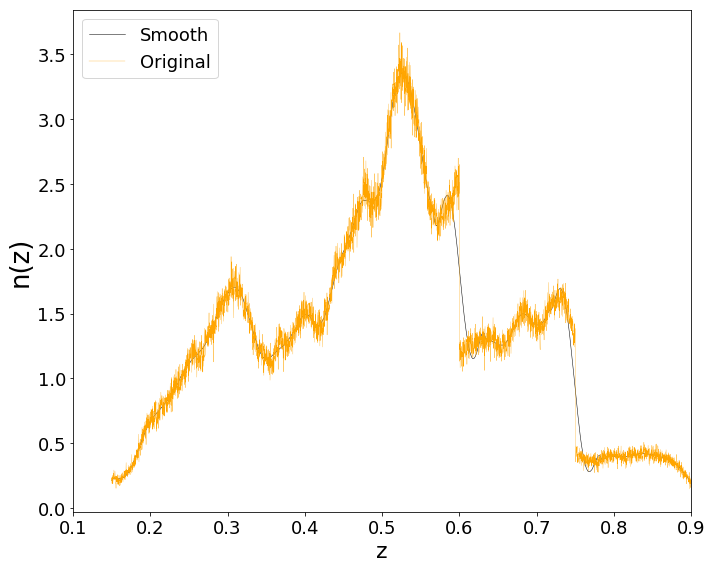

In [14]:
fig, ax = plt.subplots(1,1, figsize = (10,8))
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(0.1,0.9)
# ax.set_ylim(0.0,1.5)
ax.plot(zarray, nz_normed_smooth, 'k-', label='Smooth',linewidth=0.5)
ax.plot(zarray, nz_normed, 'orange', label='Original',linewidth=0.3)


ax.legend(fontsize=18, loc='upper left')
plt.xlabel(r'z', fontsize=22)
plt.ylabel(r'n(z)', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)
plt.tight_layout()
# plt.savefig('/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/process_cats/halos_nz_M_13.0_13.5_theory.png')




In [2]:
def eq2ang(ra, dec):
    phi = ra * np.pi / 180.
    theta = (np.pi / 2.) - dec * (np.pi / 180.)
    return theta, phi




In [4]:
cat_b = fits.open('/global/project/projectdirs/des/shivamp/actxdes/data_set/buzzard_sims/downsampled_matter_catalog_dm_from_orig_0.3.fits')[1].data  

ra_all, dec_all, z_all = cat_b['RA'], cat_b['DEC'], cat_b['Z']





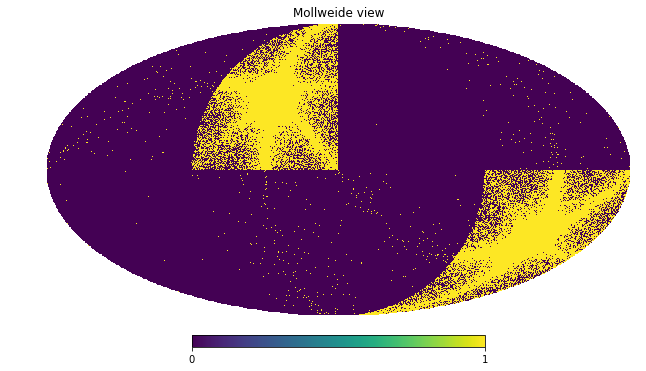

In [6]:
import healpy as hp
theta_all, phi_all = eq2ang(ra_all, dec_all)
nside_mask = 512
ind_g_f = hp.ang2pix(nside_mask, theta_all, phi_all)
mask_d = np.zeros(hp.nside2npix(nside_mask))
mask_d[ind_g_f] = 1
plt.figure()
hp.mollview(mask_d)
# plt.savefig('/global/project/projectdirs/des/shivamp/actxdes/data_set/buzzard_sims/measurements/' + 'data_m_sky.png')




In [7]:
import h5py as h5
from astropy.io import fits
import numpy as np
import healpy as hp

def ang2eq(theta, phi):
    ra = phi * 180. / np.pi
    dec = 90. - theta * 180. / np.pi
    return ra, dec

fname = '/project/projectdirs/des/jderose/Chinchilla/Herd/Chinchilla-3/v1.9.8/sampleselection/Y3a/mastercat/Buzzard-3_v1.9.8_Y3a_mastercat.h5'
cat = h5.File(fname, 'r')
mcat = cat['catalog/downsampled_dm']

px = mcat['px'][()]
ntotal = len(px)
dm = 10

ind_sel = np.unique(np.random.randint(0,ntotal, int(ntotal/dm)))

px, py, pz = mcat['px'][()][ind_sel],mcat['py'][()][ind_sel],mcat['pz'][()][ind_sel]




In [11]:
r2d = 180./np.pi
dist = np.sqrt(px**2.0+py**2.0+pz**2.0)
# theta = np.arccos(np.abs(pz/dist))
theta = np.arccos((pz/dist))
phi   = np.abs(np.arctan(py/px))
theta = theta*r2d
phi   = phi*r2d
dec   = 90 - theta
ra    = phi



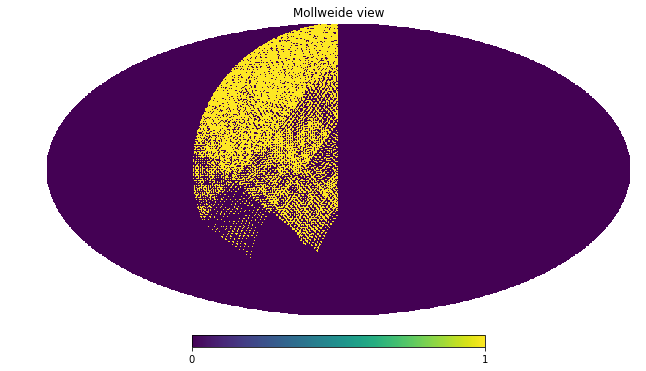

In [12]:
nside_mask = 512
ind_g_f = hp.ang2pix(nside_mask, theta/r2d, phi/r2d)
mask_d = np.zeros(hp.nside2npix(nside_mask))
mask_d[ind_g_f] = 1
plt.figure()
hp.mollview(mask_d)



In [15]:
theta_hp, phi_hp = hp.vec2ang(np.array([px,py,pz]), lonlat=True)
ra_hp, dec_hp = ang2eq(theta_hp, phi_hp)



In [16]:
nside_mask = 512
ind_g_f = hp.ang2pix(nside_mask, theta_hp, phi_hp)
mask_d = np.zeros(hp.nside2npix(nside_mask))
mask_d[ind_g_f] = 1
plt.figure()
hp.mollview(mask_d)




ValueError: THETA is out of range [0,pi]